In [1]:
import os
import numpy as np
import pandas as pd
import squidpy as sq
# from decoupler import p_adjust_fdr

import muon as mu

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

from scipy.stats import ttest_rel

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = os.path.join('..','..', 'data', 'sma')
slides = pd.read_csv(os.path.join(path, "sma_meta.csv"), index_col=0).index

In [3]:
palette = {'Intact': '#1f77b4', 'Lesioned': '#F7671A'}
views = {'receptor': 'Receptors', 'ct':'Cell types'}
view_palette = {"Receptors":"#008B8B", "Cell types":"#a11838"}

In [4]:
target_metrics = pd.read_csv(os.path.join('results', "target_metrics.csv"), index_col=None)
interactions = pd.read_csv(os.path.join('results', "interactions.csv"), index_col=None)
# prettify
target_metrics['intra_group'] = target_metrics['intra_group'].str.capitalize()
target_metrics.rename(columns=views, inplace=True)
interactions['view'] = interactions['view'].replace(views)

In [5]:
mdata = mu.read_h5mu("results/B1_local.h5mu")

## Visualize

In [6]:
targets = target_metrics.groupby(['target', 'intra_group']).agg({"gain_R2":'mean'}).sort_values("gain_R2", ascending=False).reset_index()
top_targets = targets['target'].unique()[0:10]
# as categorical with levels from targets
target_metrics['target'] = pd.Categorical(target_metrics['target'], categories=targets['target'].unique())
metrics = target_metrics[target_metrics['target'].isin(top_targets)]
metrics['target'] = pd.Categorical(metrics['target'], categories=top_targets)
metrics['intra_group'] = pd.Categorical(metrics['intra_group'], categories=['Lesioned', 'Intact'])

In [7]:
dop_ints = interactions[interactions['target']=='Dopamine'].copy()
# predictors with highest importances
dop_ints = (dop_ints[dop_ints['intra_group']=='intact'].
            groupby(['target', 'predictor', 'view']).
            # agg by mean and count
            agg({"importances":'median', 'slide':'count'}).
            rename(columns={'slide':'count'}).
            reset_index()
            )

dop_ints['rank'] = dop_ints.groupby('target')['importances'].rank(ascending=False)
dop_ints['View'] = dop_ints['view']


Check Reviewer requests

In [65]:
dop_ints[dop_ints['predictor'].isin(["Drd1", 'MBDOP1', 'MBDOP2', 'OBDOP1', 'OBDOP2', 'Cholinergic and monoaminergic neurons'])]

,target,predictor,view,importances,count,rank,View
6,Dopamine,Cholinergic and monoaminergic neurons,Cell types,0.814406,3,23.0,Cell types
17,Dopamine,Drd1,Receptors,1.897710,3,7.0,Receptors
47,Dopamine,MBDOP1,Cell types,0.270940,3,36.0,Cell types
48,Dopamine,MBDOP2,Cell types,0.916145,3,21.0,Cell types
56,Dopamine,OBDOP1,Cell types,1.118230,3,16.0,Cell types
57,Dopamine,OBDOP2,Cell types,0.452825,3,32.0,Cell types


Plot Functions

In [94]:
def plot_r2(metrics, targets=['Dopamine'], ax=None):
    data = metrics[metrics['target'].isin(targets)]
    data['target'] = pd.Categorical(data['target'], categories=['Dopamine'])
    data['intra_group'] = pd.Categorical(data['intra_group'], categories=['Intact', 'Lesioned'])

    if ax is None:
        fig, ax = plt.subplots()

    if len(targets)==1:
        x = 'intra_group'
        dodge=False
    else:
        x = 'target'
        dodge=True

    sns.violinplot(x=x, y='gain_R2', hue='intra_group', data=data, palette=palette, ax=ax, dodge=dodge)
    sns.stripplot(x=x, y='gain_R2', hue='intra_group', data=data, dodge=dodge, jitter=True, size=3, palette=palette, ax=ax)

    ax.set_xlabel('')
    ax.set_ylabel('R2')
    ax.set_ylim(-0.05, 1)
    sns.despine(ax=ax)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize('x-large')

    if ax is None:
        plt.show()

In [95]:
from scipy.stats import ttest_ind

def plot_contributions(metrics, targets, add_signif=False, ax=None):
    data = metrics[((metrics['target'].isin(targets)) & (metrics['intra_group']=="Intact"))]
    data['target'] = pd.Categorical(data['target'], categories=targets)
    data = data.melt(id_vars=['target', 'intra_group'], value_vars=views.values(), var_name='View', value_name='Contribution')

    if ax is None:
        fig, ax = plt.subplots()
        
    if len(targets)==1:
        x = 'View'
        dodge=False
    else:
        x = 'target'
        dodge=True

    sns.barplot(data=data, x=x, y='Contribution', hue='View', palette=view_palette, ci=95, errwidth=2, ax=ax, dodge=dodge)
    ax.set_title("")
    ax.set_xlabel("")
    
    # Rotate x-axis labels by 90 degrees
    if len(targets) > 1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    # Increase all font sizes
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize('xx-large')

    # Perform t-test if add_signif is True
    if add_signif:
        intact = data[data['View'] == 'Receptors']['Contribution'].values
        lesioned = data[data['View'] == 'Cell types']['Contribution'].values
        t_stat, p_val = ttest_ind(lesioned, intact)
        # Add t-test results as a text label on the top right of the plot
        ax.text(0.5, 0.95, f'P-value={p_val:.3f}',
                horizontalalignment='right', verticalalignment='top', 
                transform=ax.transAxes, fontsize='xx-large')

    if ax is None:
        plt.show()

In [96]:
def plot_violin(metrics, palette, x, dodge=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the size to accommodate your number of categories

    # Create the violin plot with an alpha of 0.5
    sns.violinplot(x=x, y='gain_R2', hue='intra_group', data=metrics, palette=palette, dodge=dodge, ax=ax)

    # Add the dots using stripplot
    sns.stripplot(x='target', y='gain_R2', hue='intra_group', data=metrics, dodge=True, jitter=True, size=3, palette=palette, ax=ax)

    # Customizing the plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
    ax.set_xlabel('Metabolite Peak', fontsize=18)
    ax.set_ylabel('R2', fontsize=18)
    ax.set_ylim(-0.05, 1)
    sns.despine(ax=ax)

    # Increase tick text size
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:2], labels[0:2], fontsize=16, title='Condition', title_fontsize=18)

    if ax is None:
        plt.tight_layout()
        plt.show()

In [97]:
def plot_interactions(interactions, ax=None):
    # Check if ax is provided, if not use plt.gca()
    if ax is None:
        ax = plt.gca()

    # Create the scatter plot on the provided ax
    sns.scatterplot(x='rank', y='importances', palette=view_palette, hue='View', data=dop_ints, ax=ax, s=30)

    # Label the top interactions
    topn = interactions.nlargest(3, 'importances')
    texts = []
    for x, y, label in zip(topn['rank'], topn['importances'], topn['predictor']):
        text = ax.text(x, y, label, fontsize='xx-large', ha='left', va='center')
        texts.append(text)

    # Use adjust_text
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color='grey', lw=1.5), expand_points=(1.2, 1.4), expand_text=(1.2, 1.4))

    # Add labels and a title
    ax.set_xlabel('Rank')
    ax.set_ylabel('Importance')

    # Increase all fontsizes
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize('xx-large')

    # Add legend title
    ax.legend(fontsize='xx-large', bbox_to_anchor=(0.5, 0.975), loc='upper left', title='View', title_fontsize='xx-large')


In [98]:
from matplotlib.colors import ListedColormap
cat_palette = ListedColormap(sns.color_palette(['#1f77b4', 'lightgray', '#e62e00']).as_hex())

def plot_scores(scores, interaction, labs = ['G)', 'H)', 'I)'], filename=None):
    scores.obs['Category'] = scores[:, interaction].layers['cats'].A.flatten()
    scores.obs['Category'] = scores.obs['Category'].replace({1:'Positive', -1:'Negative', 0:'Neither'})

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sq.pl.spatial_scatter(scores, color=[interaction], size=1.5, vmax=1, vmin=0, ax=axes[0], img=False, frameon=False, title='')
    sq.pl.spatial_scatter(scores, color=[interaction], layer='pvals', size=1.5, cmap='magma_r', vmax=1, ax=axes[1], img=False, frameon=False, title='')
    sq.pl.spatial_scatter(scores, color=['Category'], palette=cat_palette, size=1.5, vmax=1, vmin=-1, ax=axes[2], img=False, frameon=False, title='')

    labels = ["Cosine Similarity", "P-value"]

    for ax, label in zip(axes.flat[0:2], labels):
        cbar = ax.collections[0].colorbar
        cbar.set_label(label, rotation=270, labelpad=25, fontsize='xx-large')
        cbar.ax.tick_params(labelsize='xx-large')
        
    for i, ax in enumerate(axes):
        ax.text(-0.05, 1.15, labs[i], transform=ax.transAxes, fontsize=35, fontweight='bold', va='top', ha='right')
    ax.legend(fontsize='x-large', bbox_to_anchor=(0.6, 1.1), loc='upper left', title='Category', title_fontsize='x-large')

    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    else:
        plt.show()

## Figure 2

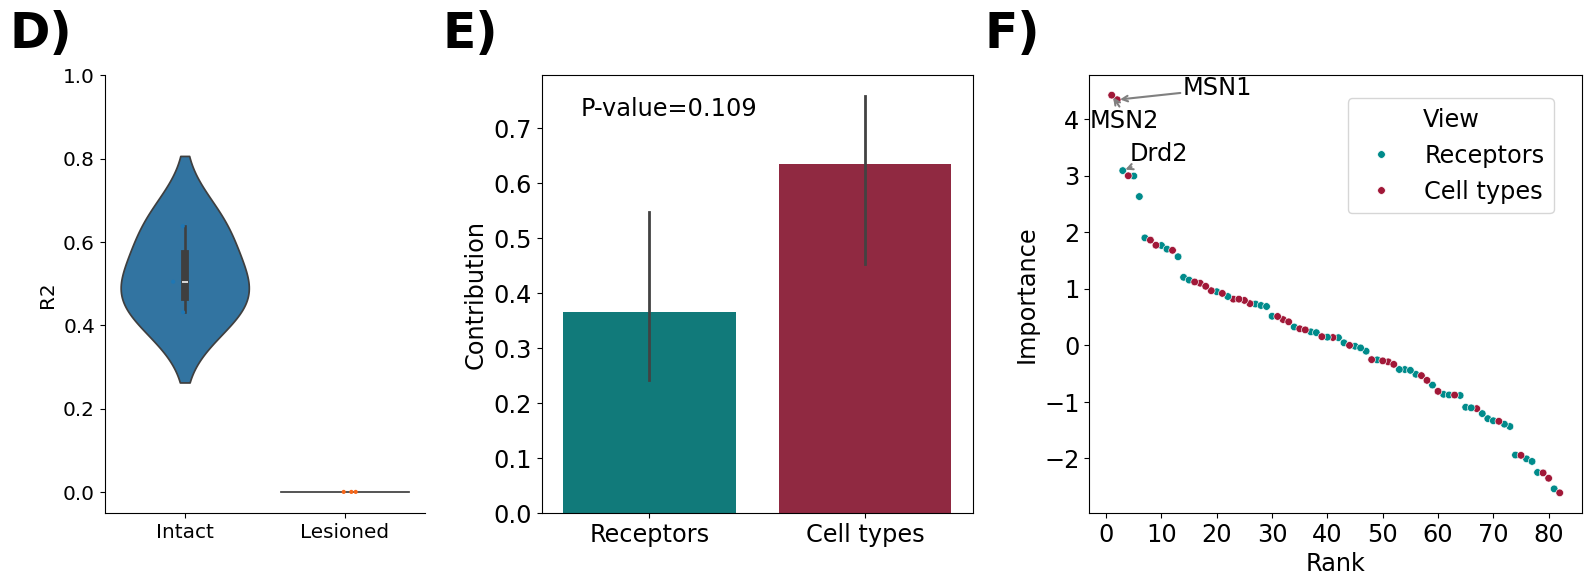

In [99]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(16, 6))

# Define GridSpec for 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1.3, 1.75, 2])

# Create subplots for the first row with different sizes
ax0 = plt.subplot(gs[0, 0])  # Smaller subplot
ax1 = plt.subplot(gs[0, 1])  # Larger subplot
ax2 = plt.subplot(gs[0, 2])  # Larger subplot

# Now you can use your function to plot in these subplots
plot_r2(metrics, ax=ax0)  # For the first subplot in the first row
plot_contributions(metrics, targets=['Dopamine'], ax=ax1, add_signif=True)  # For the second subplot in the first row
plot_interactions(dop_ints, ax2)  # For the third subplot in the first row

labs = ['D)', 'E)', 'F)']
for i, ax in enumerate([ax0, ax1, ax2]):
    ax.text(-0.1, 1.15, labs[i], transform=ax.transAxes, fontsize=35, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(wspace=0.1, hspace=0.2)
fig.tight_layout()

plt.savefig(os.path.join("..", "..", "figures", "Fig2D-F.pdf"), dpi=300, bbox_inches='tight')
plt.show()


In [100]:
scores = mdata.mod['lr']

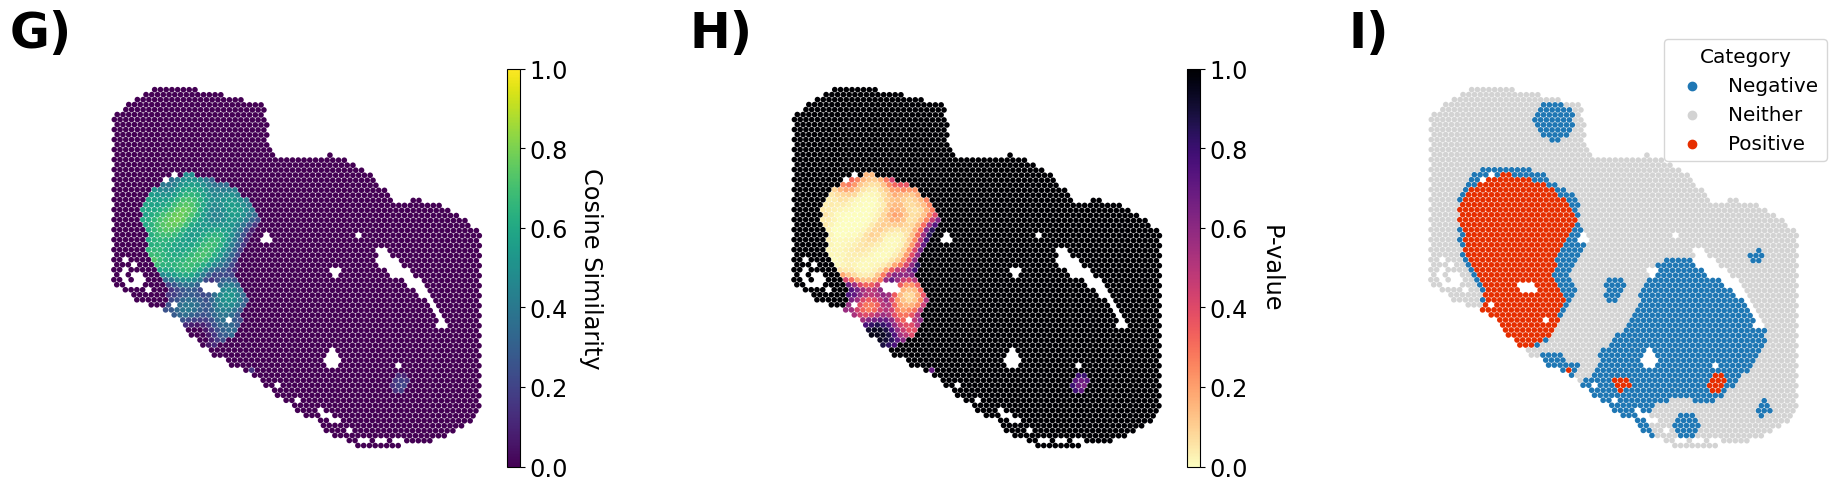

In [101]:
plot_scores(scores, interaction='Dopamine^Drd2', filename=os.path.join("..", "..", "figures", "Fig2G-I.pdf"))

### Supplementary Table

In [102]:
met = metrics[metrics['target']=='Dopamine'].copy()
met.rename(columns={'gain_R2':'R2'}, inplace=True)
met.to_csv(os.path.join("..", "..", "figures", "source", 'Fig2D&F.csv'))

In [103]:
interactions[interactions['target']=='Dopamine'].to_csv(os.path.join("..", "..", "figures", "source", 'Fig2E.csv'))

## Supp Fig

In [104]:
mdata.mod['msi'].obs['Condition'] = mdata.mod['rna'].obs['lesion'].str.title()
mdata.mod['msi'].obs['Region'] = mdata.mod['rna'].obs['region'].str.title()
# gray and cyan
region_palette = ListedColormap(sns.color_palette(['lightgray', '#0091b5',]).as_hex())

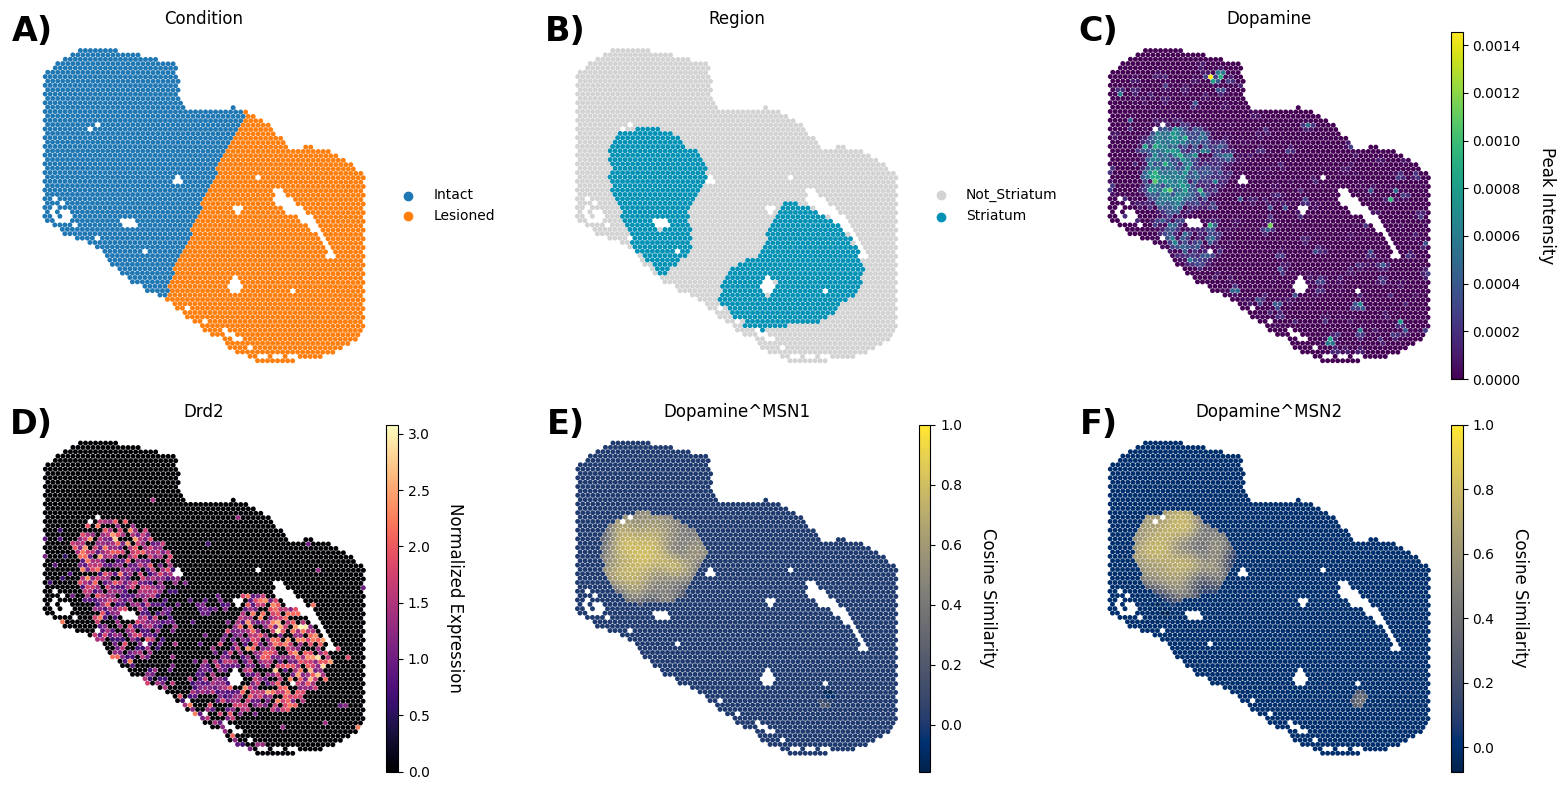

In [105]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
sq.pl.spatial_scatter(mdata.mod['msi'], color=['Condition'], size=1.5, ax=axes[0, 0], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['msi'], color=['Region'], size=1.5, ax=axes[0, 1], img=False, frameon=False, palette=region_palette)
sq.pl.spatial_scatter(mdata.mod['msi'], color=['Dopamine'], size=1.5, cmap="viridis", ax=axes[0, 2], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['rna'], color=['Drd2'], size=1.5, cmap='magma', ax=axes[1, 0], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['msi_ct'], color=['Dopamine^MSN1'], size=1.5, cmap="cividis", ax=axes[1, 1], img=False, frameon=False, vmax=1)
sq.pl.spatial_scatter(mdata.mod['msi_ct'], color=['Dopamine^MSN2'], size=1.5, cmap='cividis', ax=axes[1, 2], img=False, frameon=False, vmax=1)

labels = ["Peak Intensity", "Normalized Expression", "Cosine Similarity", "Cosine Similarity"]

# Loop over the axes and set the colorbar labels
for ax, label in zip(axes.flat[2:], labels):  # ax.flat if ax is a 2D array
    cbar = ax.collections[0].colorbar
    # reduce height of colorbar
    box = cbar.ax.get_position()
    cbar.ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])
    cbar.set_label(label, rotation=270, labelpad=25, fontsize='large')

labs = ['A)', 'B)', 'C)', 'D)', 'E)', 'F)']
for i, ax in enumerate(axes.flat):
    ax.text(0.075, 1.05, labs[i], transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig(os.path.join("..", "..", "figures", "Sufig_SMA.pdf"), dpi=300, bbox_inches='tight')
plt.show()

## SF2

In [106]:
metrics['target'] = pd.Categorical(metrics['target'], categories=metrics['target'].unique())

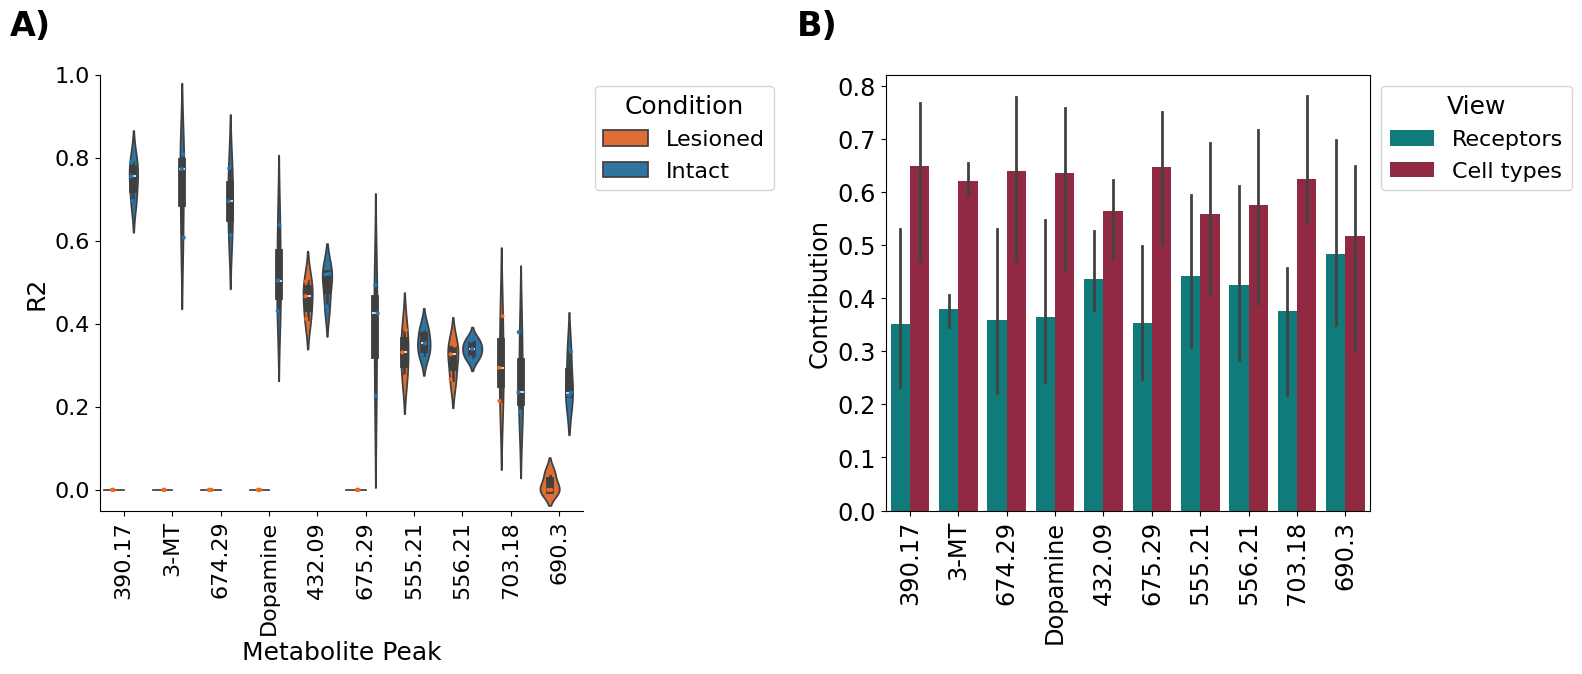

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plot_violin(metrics, palette, x='target', dodge=True, ax=axes[0])
plot_contributions(metrics=metrics, targets=metrics['target'].unique(), ax=axes[1])

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[0:2], labels[0:2], loc='upper left', bbox_to_anchor=(1, 1), fontsize=16, title='Condition', title_fontsize=18)

axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16, title='View', title_fontsize=18)

labels = ['A)', 'B)']
for i, ax in enumerate(axes):
    ax.text(-0.1, 1.15, labels[i], transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig(os.path.join("..", "..", "figures", "Sufig_SMA_misty.pdf"), dpi=300)
plt.show()

In [108]:
predictors = ["MSN1", "MSN2", "Drd2"]
dopamine = interactions[(interactions['target']=='Dopamine') & interactions['predictor'].isin(predictors)].copy()

In [109]:
pvals = pd.DataFrame(columns=['predictor', 'pval'])
for predictor in predictors:
    predictor_msk = (dopamine['predictor']==predictor)
    group1 = dopamine[predictor_msk & (dopamine['intra_group']=='intact')].copy()
    group2 = dopamine[predictor_msk & (dopamine['intra_group']=='lesioned')].copy()
    tt = ttest_rel(group1['importances'], group2['importances'], alternative='greater')
    pvals.loc[len(pvals)] = [predictor, tt.pvalue]
pvals.set_index('predictor', inplace=True)

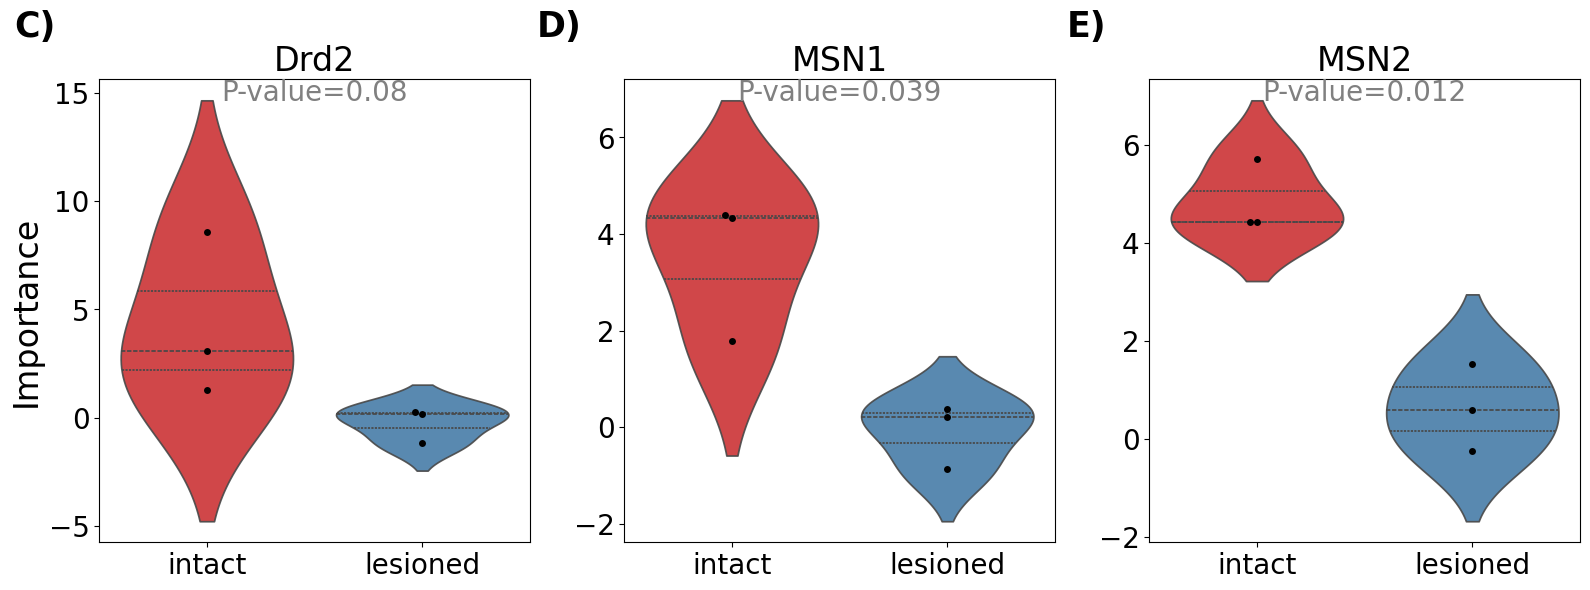

In [110]:
fig = plt.figure(figsize=(16, 6))

# PLOT C, D, E
predictors = dopamine['predictor'].unique()

# add a gridspec
gs = fig.add_gridspec(1, len(predictors))

for i, pred in enumerate(predictors):
    ax = fig.add_subplot(gs[i])
    data = dopamine[dopamine['predictor'] == pred]
    sns.violinplot(x='intra_group', y='importances', data=data, split=False, inner='quart', alpha=0.9, palette='Set1', cut=2)
    sns.swarmplot(x='intra_group', y='importances', data=data, color='black')
    pval_label = f'P-value={round(pvals.loc[pred]["pval"], 3)}'
    ax.text(0.5, 0.94, pval_label, ha='center', va='bottom', transform=ax.transAxes, color='gray', size=20)
    ax.set_title(pred, fontsize=24)
    ax.set_xlabel('')
    ax.set_ylabel('Importance' if i == 0 else '', fontsize=24)  # Increased fontsize for y-axis title
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increased fontsize for x and y-axis ticks

# Add labels
labels = ['C)', 'D)', 'E)']
for i, ax in enumerate(fig.get_axes()):
    ax.text(-0.1, 1.15, labels[i], transform=ax.transAxes, fontsize=25, fontweight='bold', va='top', ha='right')

# add spaces between subfigs
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.savefig(os.path.join("..", "..", "figures", "Sufig_SMA_violin.pdf"), dpi=300)
plt.show()

### Suplementary Table

In [26]:
metrics.to_csv(os.path.join("..", "..", "figures", "source", "Sufig4A&B.csv"))

In [27]:
dopamine.to_csv(os.path.join("..", "..", "figures", "source", "Sufig4C-E.csv"))